# Ray Sampling

In this notebook we will compare different techniques of splitting a single ray into many. This is useful for replacing non-differentiable binary pixel values with continuous values.

In [1]:
from collections import namedtuple
from IPython.display import display

import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

import source.tensorize as t
from source.scene import *
from source.renderer import *
from source.geometry import *

%load_ext autoreload
%autoreload 2

SyntaxError: invalid syntax (renderer.py, line 203)

## Stochastic Beam

A beam consists of an area that is intersected by nearly-parallel rays. 
Approximate beam with Gaussianly distributed rays. To be precise the angular deviation, which forms the area, is Gaussianly distributed. The standard deviation of the stochastic approximation is shaped like a cone. The of cone is 

![stochastic beam](./images/stochastic_beam.png)


To sample rays from this Gaussian distibution let us write an auxiliary function 

In [2]:
def sample_angular_dispersion(directions, n_samples=10, angular_std=None):
    assert len(directions.shape) == 2 and directions.shape[1] == 3, \
        'Directional vectors should have shape (N,3)'
    N = directions.shape[0]
    
    if angular_std is None: angular_std = np.deg2rad(5.0)
    angular_std = np.asarray([angular_std])
    if len(angular_std.shape)==0 or angular_std.shape==(1,): 
        angular_std = np.repeat(angular_std, N, axis=0)
        
    assert len(angular_std.shape) == 1 and angular_std.shape[0] == N, \
        'Angular standards should have same number of elements as directional vectors.'
    
    #sample rotation axis uniformly from sphere via rejection sampling
    attempts = 100
    correct_samples = np.zeros((N, n_samples), dtype=np.uint8)
    rotation_axis = np.random.normal(size=(N,n_samples,3))
    for _ in range(attempts): #attempt to sample from normal distribution without getting zero 
        print('Angular dispersion sampling attempt number ', _)
        sampled_rotation_axis = np.random.normal(size=(N,n_samples,3))
        sampled_rotation_axis = np.where(correct_samples[:,:,None], rotation_axis, sampled_rotation_axis)   
        new_correct_samples = np.sum(sampled_rotation_axis**2, axis=-1) > 1e-3
        if np.all( new_correct_samples ): break
        correct_samples = new_correct_samples
    if _ == attempts-1: print('All samples rejected! Run again.') # doesn't happen in practise!
    rotation_axis = rotation_axis / np.sqrt( np.sum(rotation_axis**2, axis=-1) )[:,:,None]
        
    #sample angle from normal distribution 
    angular_std = np.asarray(angular_std, dtype=np.double)
    angles = np.random.normal(scale=angular_std[:,None], size=(N,n_samples))
    
    #rotate directional vector according to Rodrigues' rotation formula
    d_new = np.cos(angles)[:,:,None] * directions[:,None,:]
    cross_product = np.cross(d_new, rotation_axis) #.cpu().numpy(), directions.cpu().numpy()[:,None,:])
    d_new = d_new + np.sin(angles)[:,:,None] * np.asarray(cross_product, dtype=d_new.dtype)
    rotation_axis = np.asarray(rotation_axis, dtype=directions.dtype)
    d_new = d_new + (1-np.cos(angles))[:,:,None] * rotation_axis * \
        np.sum(rotation_axis * directions[:,None,:], axis=-1)[:,:,None] 
    
    return d_new

Angular dispersion sampling attempt number  0


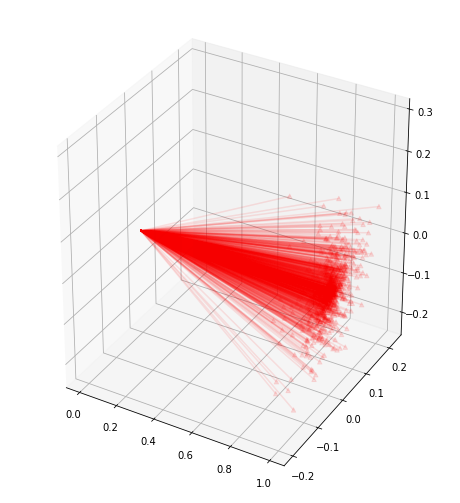

In [3]:
#Unit test
rays = np.asarray([[1,0,0]])
rays = sample_angular_dispersion(rays, 1000, np.deg2rad(5.))
rays = rays[0,:,:]
                                
fig = plt.figure(figsize=(8,9))
ax = plt.axes(projection='3d')

x,y,z = rays[:,0],rays[:,1],rays[:,2]
#x,y,z = x.cpu().numpy(), y.cpu().numpy(), z.cpu().numpy()
ax.scatter(x, y, z, c='r', marker='^', alpha=.1)

N = rays.shape[0]
for r in range(N):
    plt.plot([0,x[r]],[0,y[r]],[0,z[r]], color='r', alpha=.1)

plt.show()

Tbis approach creates very noisy rays when we used fixed angles. We assume the angular dispersion has to be chosen very carefully and depending on the distance to the intersection to be able to give any good results.    

## Edge Subsampling



In [4]:
#load scene
scene = parse_scene('./scenes/small03.yaml')

In [5]:
#construct rays
camera = scene['camera']
camera = tensorize_scene_object(camera)
w,h = camera['width'], camera['height']
rays = construct_initial_rays(camera)

The binary silhuette mask $\xi_{ij} \in \{0,1\}$ is not differentiableand the pixels are either black or white depending on whether the object is visible. 

In [6]:
#intersection
ball = scene['ball']
ball = tensorize_scene_object(ball)
depth = intersect_rays_with_sphere(rays, ball)
mask = depth > 1e-3
mask = mask.reshape(w,h)

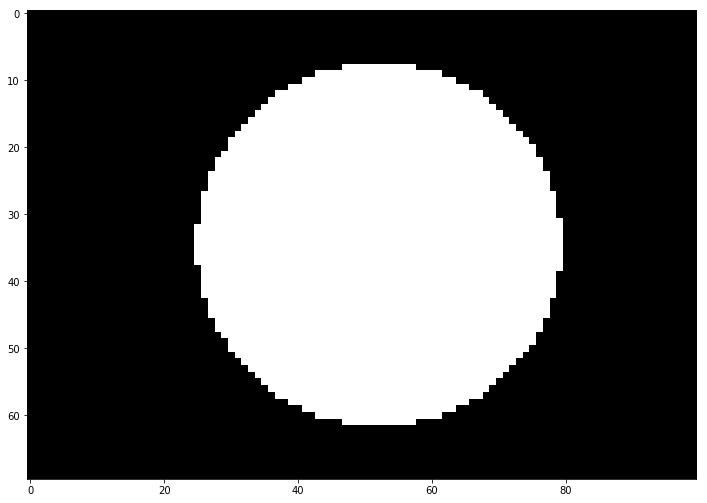

In [7]:
img = mask
img = t.detach_numpy(img).transpose()
plt.figure(figsize=(12,9))
plt.imshow(img, cmap='gray')
plt.show()

Now calculate an edge which occurs can be detected by comparing $\xi$ to the average over neighboring pixels $\bar\xi$. More precisely the edge condition is
$$ | \xi_{ij} - \bar \xi_{ij} | = 0  \quad \text{with } \bar \xi  =  \xi \ast \frac 19 
\begin{pmatrix} 
1 & 1 & 1 \\
1 & 1 & 1 \\
1 & 1 & 1 \\
\end{pmatrix} 
= \text{box-filter}(\xi)
$$

In [8]:
def edges_from_silhuette(silhuette):
        silhuette = silhuette.float()
        neighs = t.ones((3,3), dtype=t.float) / 9.
        edges = t.conv2d(silhuette[None,None,:,:], neighs[None,None,:,:])
        edges = edges[0,0,:,:]
        
        edges = 2.*t.abs( edges - silhuette[1:-1, 1:-1]) 
        return edges

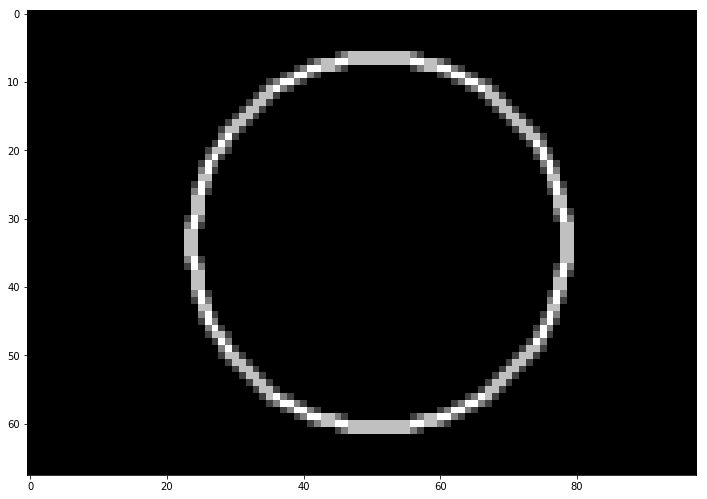

In [9]:
edges = edges_from_silhuette(mask)
img = t.detach_numpy( edges )
plt.figure(figsize=(12,9))
plt.imshow(img.transpose(), cmap='gray',interpolation='nearest')
plt.show()

It is more efficient to represent the edges as list of indices, since the number of edge pixels is probably very small compared to the number of non-edge pixels. 

In [10]:
print('edge indices: ', t.nonzero(edges).shape[0])
print('edge mask: ', edges.shape[0]*edges.shape[1])
indices =  t.nonzero(edges)+1
center_indices = indices[:,0]*mask.shape[1] + indices[:,1]
left_indices   = (indices[:,0]-1)*mask.shape[1] + indices[:,1]
right_indices  = (indices[:,0]+1)*mask.shape[1] + indices[:,1]
bottom_indices = indices[:,0]*mask.shape[1] + indices[:,1]-1
top_indices = indices[:,0]*mask.shape[1] + indices[:,1]-1

edge indices:  436
edge mask:  6664


In [12]:
indices

tensor([[24, 31],
        [24, 32],
        [24, 33],
        [24, 34],
        [24, 35],
        [24, 36],
        [24, 37],
        [24, 38],
        [25, 26],
        [25, 27],
        [25, 28],
        [25, 29],
        [25, 30],
        [25, 31],
        [25, 32],
        [25, 33],
        [25, 34],
        [25, 35],
        [25, 36],
        [25, 37],
        [25, 38],
        [25, 39],
        [25, 40],
        [25, 41],
        [25, 42],
        [25, 43],
        [26, 23],
        [26, 24],
        [26, 25],
        [26, 26],
        [26, 27],
        [26, 28],
        [26, 29],
        [26, 30],
        [26, 31],
        [26, 32],
        [26, 37],
        [26, 38],
        [26, 39],
        [26, 40],
        [26, 41],
        [26, 42],
        [26, 43],
        [26, 44],
        [26, 45],
        [26, 46],
        [27, 21],
        [27, 22],
        [27, 23],
        [27, 24],
        [27, 25],
        [27, 26],
        [27, 27],
        [27, 42],
        [27, 43],
        [2

torch.Size([43600])
torch.Size([436])
torch.Size([7000])


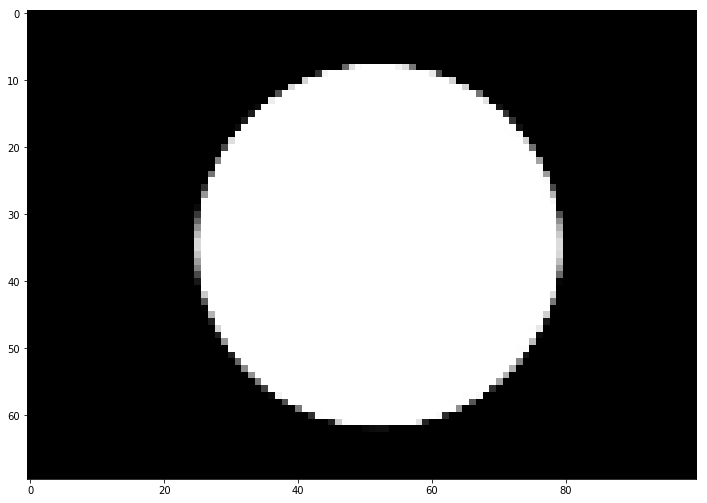

In [11]:
n=10 #number of subsamples

s,d = rays
    
ii,jj = np.mgrid[:n,:n]
xx = 2.* ( t.astensor(ii,dtype=t.float) + .5)/n - 1.
yy = 2.* ( t.astensor(jj,dtype=t.float) + .5)/n - 1.
xx,yy = xx[None,:,:,None],yy[None,:,:,None]
z = t.zeros((n,n))[None,:,:,None]

s_sub = ((1.-xx)+(1.-yy)) * s[center_indices,None, None,:]
s_sub = s_sub + t.where(xx > 0, xx * s[right_indices,None, None,:],z)
s_sub = s_sub - t.where(xx < 0, xx * s[left_indices,None, None,:],z)
s_sub = s_sub + t.where(yy > 0, yy * s[top_indices,None, None,:],z)
s_sub = s_sub - t.where(yy < 0, yy * s[bottom_indices,None, None,:],z)
s_sub = .5 * s_sub

d_sub = ((1.-xx)+(1.-yy)) * d[center_indices,None, None,:]
d_sub = d_sub + t.where(xx > 0, xx * d[right_indices,None, None,:],z)
d_sub = d_sub - t.where(xx < 0, xx * d[left_indices,None, None,:],z)
d_sub = d_sub + t.where(yy > 0, yy * d[top_indices,None, None,:],z)
d_sub = d_sub - t.where(yy < 0, yy * d[bottom_indices,None, None,:],z)
d_sub = .5 * d_sub

s_sub = s_sub.reshape((-1,3))
d_sub = d_sub.reshape((-1,3))
depth_sub = intersect_rays_with_sphere((s_sub,d_sub), ball)
mask_sub = depth_sub > 1e-3
mask_sub = mask_sub.float()
print(mask_sub.shape)
values = mask_sub.reshape((-1,n**2))
values = t.sum(values, axis=-1)/n**2
print(values.shape)
visibility = mask.float().reshape(w*h)
print(visibility.shape)
visibility[center_indices] = values
visibility = visibility.reshape(w,h)

img = t.detach_numpy(visibility).transpose()
plt.figure(figsize=(12,9))
plt.imshow(img, cmap='gray')
plt.show()